<a href="https://colab.research.google.com/github/emrecicekyurt/DeepLearningProjects/blob/main/FoodVisionBigProject%E2%84%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project: Food Vision Big

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8cff029d-0bba-11b0-4a35-7e79ecda7056)


In [2]:
# Get helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-21 10:45:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-21 10:45:29 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
## Use TensorFlow Datasets to download dataset
import tensorflow_datasets as tfds

In [5]:
# Listing some available datasets
datasets_list= tfds.list_builders()
datasets_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc']

In [6]:
# Is our target dataset in list of tfds datasets?
print("food101" in datasets_list)

True


In [7]:
# Load in data (5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, #returns as a tuple e.g (data,label)
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete9K4QA2/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete9K4QA2/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
# Features of dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
#get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of train dataset
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
 # Output info about trainin sample
 for image,label in train_one_sample:
   print(f"""
   Image shape: {image.shape}
   Image datatype: {image.dtype}
   Target class (tensor form): {label}
   Class names : {class_names[label.numpy()]}
   """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class (tensor form): 21
  Class names : chocolate_cake
  


In [12]:
# What does our image tensor look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 32,  14,   0],
        [ 31,  13,   0],
        [ 28,  12,   0],
        ...,
        [ 54,  34,  10],
        [ 53,  33,   9],
        [ 51,  31,   7]],

       [[ 28,  10,   0],
        [ 28,  10,   0],
        [ 27,  11,   0],
        ...,
        [ 56,  36,  12],
        [ 55,  35,  11],
        [ 54,  34,   9]],

       [[ 30,  12,   0],
        [ 31,  13,   0],
        [ 31,  15,   0],
        ...,
        [ 58,  38,  13],
        [ 58,  38,  13],
        [ 58,  38,  11]],

       ...,

       [[135,  80,   0],
        [136,  81,   1],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[137,  82,   2],
        [137,  82,   2],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[136,  81,   1],
        [135,  80,   0],
        [135,  80,   0],
        ...,
        [ 14,   7,   

In [54]:
# What are the min max values of our image
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)



(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

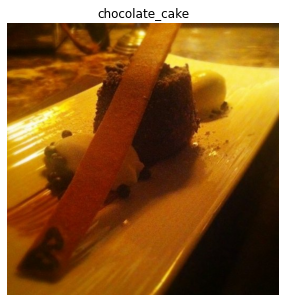

In [14]:
# Plot an image from the dataset :)
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.title(class_names[label.numpy()])
plt.imshow(image)
plt.axis(False)


In [15]:
# Create preprocessing functions for our data
def preprocess_image(image, label, image_shape=224):
  """
  Converts image datatype from 'uint_8' -> 'float32' and reshapes image to
  [img_shape, img_shape, colour_channels]
  """

  image= tf.image.resize(image,[image_shape, image_shape]) # resize the target image
  return tf.cast(image, tf.float32), label # returns tuple (float_32 image, label)


In [16]:
# Preprocess a single image 
preprocessed_img = preprocess_image(image, label)[0]
print(f"Feature of normal image -> Shape: {image.shape}, DataType: {image.dtype}")
print(f"Feature of preprocessed image -> Shape: {preprocessed_img.shape}, DataType: {preprocessed_img.dtype}")


Feature of normal image -> Shape: (512, 512, 3), DataType: <dtype: 'uint8'>
Feature of preprocessed image -> Shape: (224, 224, 3), DataType: <dtype: 'float32'>


In [17]:
# Batch and prepare datasets
train_data = train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data and turn it into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [19]:
# Create tensorboard callback (import from helpers_function)
from helper_functions import create_tensorboard_callback

#Create a model checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,# saving weights easier than savign whole model
                                                      verbose=0)


In [20]:
# Setup mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [21]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [22]:
# Feature Extraction Model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable= False

# Create functional model
inputs = layers.Input(shape=input_shape, name= "input_layer")
# Note: Since EfficientNetBX models have rescaling no need to use preprocessing e.g. x= preprocessing.Rescaling(1/255.)

x=base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name ="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

#Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#Get a summary of model
model.summary()


16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                              

In [23]:
for layer in model.layers:
  print(layer.dtype)

float32
float32
float32
float32
float32


In [24]:
from numpy import dtype
# check the top ten layers of base model
for layer in model.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">


In [25]:
# Fit feature extraction model with callback
history_feature_extraction=model.fit(train_data,
                                     epochs = 3,
                                     steps_per_epoch=len(train_data),
                                     validation_data= test_data,
                                     validation_steps=(0.15*len(test_data)),
                                     callbacks = [create_tensorboard_callback(dir_name = "training_logs",
                                                                              experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220721-105716
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8222 - accuracy: 0.5571WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 190s 72ms/step - loss: 1.8222 - accuracy: 0.5571 - val_loss: 1.2332 - val_accuracy: 0.6715
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2934 - accuracy: 0.6660WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 167s 70ms/step - loss: 1.2934 - accuracy: 0.6660 - val_loss: 1.1260 - val_accuracy: 0.6959
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1427 - accuracy: 0.7035WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 164s 68ms/step - loss: 1.1427 - accuracy: 0.7035 - val_loss: 1.0846 - val_accuracy: 0.7022


In [26]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 49s 62ms/step - loss: 1.0841 - accuracy: 0.7072


[1.0840985774993896, 0.7072474956512451]

In [27]:
# Fine Tuning

base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

print(len(model.trainable_variables))

12


In [28]:
# Check which layers are trainable
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [30]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [31]:


# Fit feature extraction model with callback
history_fine_tuning=model.fit(train_data,
                              epochs = 100,
                              steps_per_epoch=len(train_data),
                              validation_data= test_data,
                              validation_steps=(0.15*len(test_data)),
                              callbacks = [create_tensorboard_callback(dir_name = "training_logs",
                                                                      experiment_name="efficientnetb0_101_classes_all_data_fine_tuning"),
                                           model_checkpoint,
                                          early_stopping, # stop model after X epochs of no improvements
                                           reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tuning/20220721-111816
Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5950 - accuracy: 0.8432WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 173s 72ms/step - loss: 0.5949 - accuracy: 0.8432 - val_loss: 0.9820 - val_accuracy: 0.7358 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5116 - accuracy: 0.8682WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 171s 71ms/step - loss: 0.5116 - accuracy: 0.8682 - val_loss: 0.9995 - val_accuracy: 0.7387 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8885WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 171s 72ms/step - loss: 0.4387 - accuracy: 0.8885 - val_loss: 1.0030 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.9276WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 170s 71ms/step - loss: 0.3209 - accuracy: 0.9276 - val_loss: 1.0241 - val_accuracy: 0.7429 - lr: 2.0000e-05


In [32]:
results_fine_tuned_model = model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.0182 - accuracy: 0.7408


In [33]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 56s 69ms/step


In [34]:
len(test_data)

790

In [69]:
# How many predictions are there?
len(pred_probs)

25250

In [72]:
# For the first prediction, lets look at the probs
print(f"Number of prediction probs for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample looks like for sample 0: {pred_probs[0]}")
print(f"The class with the highest predicted probability for sample 0: {tf.argmax(pred_probs[0])}")

Number of prediction probs for sample 0: 101
What prediction probability sample looks like for sample 0: [5.46061044e-11 2.95197811e-10 1.88713645e-11 1.72549741e-09
 2.16100329e-06 5.15914395e-12 5.55495760e-14 1.36292772e-06
 1.03189375e-12 6.69048011e-11 1.91685452e-11 3.29813054e-13
 9.15857627e-14 2.00041711e-13 8.67634520e-10 5.00041328e-12
 1.75531020e-12 1.90881138e-13 1.26772022e-07 2.11730850e-12
 1.21148952e-10 5.29260490e-11 1.12044450e-10 8.16295111e-13
 1.03780279e-13 4.25913374e-14 1.50545503e-07 2.93959171e-12
 3.12917877e-12 1.04217581e-11 7.09209438e-13 1.21148952e-10
 4.81897161e-11 3.73727145e-13 1.03624186e-10 1.58912831e-11
 1.20459132e-09 5.65768810e-09 2.14741624e-09 4.74426019e-11
 3.54582422e-12 3.93313021e-11 8.24428806e-12 6.05706540e-10
 4.31320117e-08 1.52504008e-12 2.92725710e-14 5.77969228e-10
 1.25182904e-13 2.21558261e-09 2.77478330e-06 6.72879200e-12
 8.40940262e-10 1.21148952e-10 7.87860496e-15 6.65238531e-10
 5.74678394e-09 2.44727572e-10 1.50139645